# A simple demo of the KKF on a simulated pendulum

We start with some magic and some imports.
$\renewcommand{\vec}[1]{\boldsymbol{#1}}
\newcommand{\mat}[1]{\boldsymbol{#1}}
\newcommand{\vecbs}[1]{\boldsymbol{#1}}
\newcommand{\op}[1]{\mathcal{#1}}
\newcommand{\trp}{\intercal}
\newcommand{\VPI}{\vphantom \intercal}
\newcommand{\parDeriv}[1]{\frac{\partial}{\partial #1}}
\newcommand{\RKHS}[1]{\mathcal{H}_{#1}}
\newcommand{\UpsX}{\vecbs \Upsilon_{x}}
\newcommand{\UpsXd}{\vecbs \Upsilon_{x'}}
\newcommand{\UpsXb}{\vecbs \Upsilon_{\bar x}}
\newcommand{\UpsXh}{\vecbs \Upsilon_{\hat{x}}}
\newcommand{\PhiY}{\vecbs \Phi_{y}}
\newcommand{\PhiYd}{\vecbs \Phi_{y'}}
\newcommand{\trCondOp}{\mathcal{C}_{X'|X}}
\newcommand{\trCondOpHat}{\mathcal{C}_{X'|\hat{X}}}
\newcommand{\obsCondOp}{\mathcal{C}_{Y|X}}
\newcommand{\obsCondOpd}{\mathcal{C}_{Y'|X'}}
\newcommand{\obsCondOpHat}{\mathcal{C}_{Y|\hat{X}}}
\newcommand{\reg}{\mathrm{reg}}
\newcommand{\phiState}{\vecbs \varphi}
\newcommand{\phiObs}{\vecbs \phi}
\newcommand{\prior}[1]{{#1}^{-}}
\newcommand{\post}[1]{{#1}^{+}}$

In [1]:
%load_ext Cython

import os
import sys
module_path = os.path.abspath(os.path.join('../kkr'))
sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

In [2]:
# enable inline plotting
%matplotlib inline
# uncomment this line to open a console with the same kernel
%qtconsole

import numpy as np
import pandas as pd

import scipy.linalg as linalg
import scipy.spatial as spatial
import scipy.stats as stats

import matplotlib.pyplot as plt
from ipywidgets import interact,Dropdown
import bokeh.plotting
# import bokeh.charts
bokeh.plotting.output_notebook()

from environments import Pendulum
from simulator import Simulator
from preprocessors import generate_data_windows, add_noise, select_reference_set_randomly
from kernels import ExponentialQuadraticKernel
from kkr import KernelKalmanFilter, KernelBayesFilter, SubspaceKernelKalmanFilter, SubspaceKernelBayesFilter
from kkr import tuning_kernel_kalman_filter 

Loading BokehJS ...

configure some parameters for the simulation

In [143]:
nSteps = 60
nEpisodes = 100

nTestEpisodes = 10

processNoiseStd = .0001
observationNoiseStd = .1

stateFeatures = 'theta'
obsFeatures = 'thetaNoisy'

## Simulate pendulum

In this section we generate the data for training the KKF from a simulated pendulum.
First, we initialize the pendulum simulator.
You can see [here](environments/Pendulum.py) how the dynamics are simulated.
We instantiate a `DataFrame` with the variables `theta` and `thetaDot` and sample the initial states for all episodes from the Gaussian $\mathcal{N}\left[\vec 0, \textrm{diag}(.1, .001)\right]$.
After that, we simulate all episodes for `nSteps` in parallel and finally add Gaussian white noise to the variable `theta` with variance $\sigma_\textrm{obs} = 0.5$.
Since we will need this procedure again to generate test data for the evaluation of the learned model, we wrap these steps in a function.

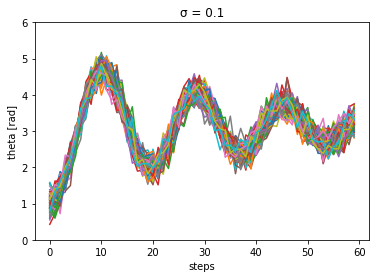

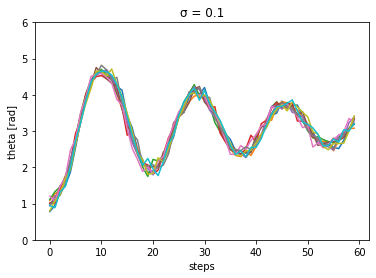

In [149]:
import math

np.random.seed(1)

# Simulate pendulum
pendulum = Pendulum()
pendulum.noise_std = processNoiseStd

# simulator = Simulator(pendulum, initVar=.01)
simulator = Simulator(pendulum, stats.norm(loc=1.0, scale=.1))

# simulate data
data = simulator.simulate(nEpisodes, nSteps)
add_noise(data, 'theta', noise_generator=stats.norm(loc=.0,scale=observationNoiseStd))
# Sample evaluation data
# pendulum = Pendulum()
# pendulum.noise_std = processNoiseStd
# pendulum.dt = 0.025
simulator = Simulator(pendulum, stats.norm(loc=1.0, scale=.1))
observationNoiseStd = .1

testData = simulator.simulate(nTestEpisodes, nSteps)
add_noise(testData, 'theta', noise_generator=stats.norm(loc=.0,scale=observationNoiseStd))

_ = data['thetaNoisy'].unstack(0).plot(xlabel="steps", ylabel="theta [rad]", legend=False,ylim=(0, 6), title="σ = 0.1");
_ = testData['thetaNoisy'].unstack(0).plot(xlabel="steps", ylabel="theta [rad]", legend=False, ylim=(0, 6), title="σ = 0.1");

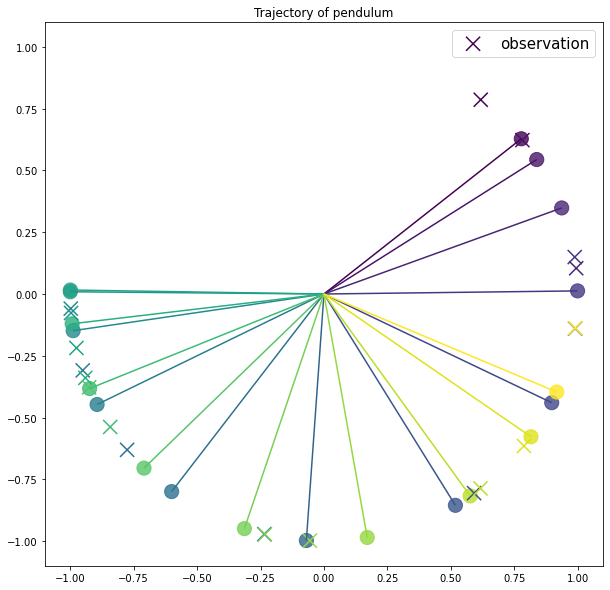

In [106]:
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors

num = 20

x = np.sin(testData.loc[(0,slice(None)),'theta'].reset_index(drop=True)[:num])
y = np.cos(testData.loc[(0,slice(None)),'theta'].reset_index(drop=True)[:num])

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_title('Trajectory of pendulum')

# pendulum thread
line_segments = LineCollection([np.array([[0,0],val]) for i, val in enumerate(np.column_stack([x, y]))], linestyles='solid')
line_segments.set_array(np.arange(num))
ax.add_collection(line_segments)

plt.sci(line_segments)  # This allows interactive changing of the colormap.

#  pendulum ball
ax.scatter(x, y, s=200, c=np.arange(num), alpha=0.8)

#  observation
obs_x = np.sin(testData.loc[(0,slice(None)),'thetaNoisy'].reset_index(drop=True)[:num])
obs_y = np.cos(testData.loc[(0,slice(None)),'thetaNoisy'].reset_index(drop=True)[:num])
obs_points = ax.scatter(obs_x, obs_y, s=200, c=np.arange(num), marker="x")
ax.legend([obs_points], ["observation"], fontsize=15)

plt.show()

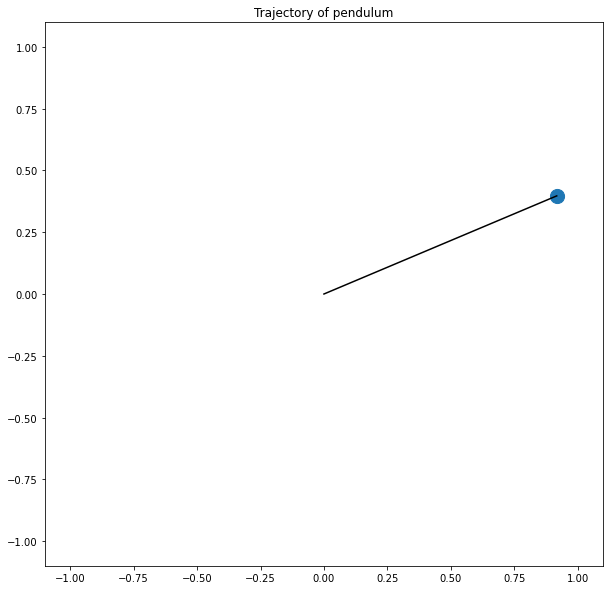

In [136]:
import matplotlib.animation as animation

num = 60
x = np.sin(data['theta'][0][:num])
y = np.cos(data['theta'][0][:num])

fig = plt.figure(figsize=(10,10))

def plot(i,x,y):
    plt.cla()
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.title('Trajectory of pendulum')
    plt.scatter(np.array(x[i]), np.array(y[i]), s=200)
    im = plt.plot(np.array([0, x[i]]), np.array([0, y[i]]), color="black")
ani = animation.FuncAnimation(fig, plot, fargs=(x,y), interval=100, frames = num)
ani.save("ot.gif", writer="imagemagick")

## Preprocess the data

Now we learn the filter from this data. First, we need to create data windows to make the data more Markovian. See [here](preprocessor/preprocessors.py) for how the data windows are generated.

In [108]:
window_size = 8

windows = generate_data_windows(data[stateFeatures],window_size).dropna()

## Learn the KKF

In this section, we show how we can now learn the models for the kernel Kalman filter from the simulated pendulum data. We first need to set some parameters, then compute some kernel matrices and from those we obtain the RKHS models in the end.

### Model parameters


In [109]:
kernel_size = 100         # number of data points in the kernel matrices
# alphaT = np.exp(-10)             # regularization parameter for the inverses
# alphaO = np.exp(-10)
# alphaQ = np.exp(-8)

Since we have two RKHSs in our model, one into which we embed the belief state and one into which we embed the distributions over the observations, we need two **kernel functions** $k$ and $g$.
For both, we need to define the **bandwidths**, $\sigma_k$ and $\sigma_g$, as hyper parameters.

There are several approaches to setting the hyperparameter.
In this example, we use the simple approach of just using one hyperparameter for all the dimensions of the input data.
Alternatively, we could also use separate hyperparameters for each dimension or choose the bandwidths for each dimension according to the *median trick* and then tune a single scaling factor for these bandwidths.

***rewrite with bandwidth selection via mean trick.***

In [110]:
np.random.seed(2)

data_subset = windows[stateFeatures].sample(300).values

bandwidths = np.zeros(data_subset.shape[1])

for i in range(data_subset.shape[1]):
    distances = spatial.distance.pdist(data_subset[:, i:i+1], metric='sqeuclidean')
    bandwidths[i] = np.sqrt(np.median(distances))

bandwidth_factor_k = np.exp(-1.5)    # bandwidth of the kernel function k
bandwidth_factor_g = np.exp(2)    # bandwidth of the kernel function g

bandwidth_k = bandwidth_factor_k * bandwidths
bandwidth_g = bandwidth_factor_g * bandwidths[0]

bandwidths_ki = [-1.5]
bandwidths_gi = [2]

bandwidths_ki = [i for i in range(-3, 3)]
bandwidths_gi = [i for i in range(-3, 3)]

### Select training data

Training the model requires triples of *state*, *next state*, and *observation*, where we use the data windows to represent the state in this case.
We already dropped the data windows with NaNs when we preprocessed the data.
In the following lines, we mark all the last data windows as they have no successors (thus, we cannot create the triples from those.)

In [111]:
# # windows.reset_index(inplace=True)
# gb = windows.groupby(level='episode')
# last_windows_idx = [gb.indices[e][-1] for e in gb.indices]

# windows['weights'] = 1
# windows.ix[last_windows_idx,'weights'] = 0

From the remaining data points, we choose a random subset for our kernel matrices.

In [112]:
np.random.seed(3)

reference_set1, reference_set2 = select_reference_set_randomly(windows, size=kernel_size,
                                                            consecutive_sets=2, group_by='episode')

In [113]:
# reference_set1 = windows.sample(n=kernel_size,weights='weights').index.sort_values()
# reference_set2 = pd.MultiIndex.from_tuples([*zip(reference_set1.labels[0],reference_set1.labels[1]+1)])
# reference_set2.set_names(reference_set1.names, inplace=True)

### Compute the kernel matrices

To compute the model matrices, we need three Gram matrices of the kernel function $k$

In [114]:
kernel_k = ExponentialQuadraticKernel()
kernel_k.bandwidth = bandwidth_k
kernel_k.normalized = True

K_11 = kernel_k.get_gram_matrix(windows.loc[reference_set1, stateFeatures].values)
K_12 = kernel_k.get_gram_matrix(windows.loc[reference_set1, stateFeatures].values, windows.loc[reference_set2, stateFeatures].values)
K_22 = kernel_k.get_gram_matrix(windows.loc[reference_set2, stateFeatures].values)

Additionally, we need one Gram matrix from the kernel function $g$.

In [115]:
kernel_g = ExponentialQuadraticKernel()
kernel_g.bandwidth = bandwidth_g
kernel_g.normalized = True

G_22 = kernel_g.get_gram_matrix(data.loc[reference_set2, obsFeatures].values.reshape((-1,1)))
k_g = lambda x: kernel_g.get_gram_matrix(data.loc[reference_set2, obsFeatures].values.reshape((-1,1)), x)

Plotting the kernel matrices allows to assess the setting of the bandwidth parameters.

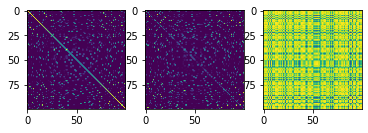

In [116]:
f, axs = plt.subplots(1,3)
_= axs[0].imshow(K_11)
_= axs[1].imshow(K_12)
_= axs[2].imshow(G_22)

### Compute model matrices

In the following lines, we compute the model matrices for the transition and observation operator.
The matrix **T** is part of the conditional embedding operator of the **forward model** and easy to understand.
The empirical estimator of the conditional embedding operator is defined as follows
\begin{align}
\trCondOp = \UpsXd (\vec{K}_{XX} + \alpha \vec I)^{-1} \UpsX^\trp.
\end{align}
Since we can embed the belief empirically with any set of samples, we can simply choose to represent it with the samples of the next state, i.e., $\mu_{t} = \UpsXd \vec m_t$, where $\vec m_t$ is a weight vector.
With that, the belief embedding after the transition becomes
\begin{align}
    \mu_{t+1} = \trCondOp \mu_t = \UpsXd (\vec{K}_{XX} + \alpha \vec I)^{-1} \UpsX^\trp \UpsXd \vec m_t = \UpsXd \vec m_{t+1}
\end{align}
Hence, we obtain the weight vector of the next state by
\begin{align}
    \vec m_{t+1} = (\vec{K}_{XX} + \alpha \vec I)^{-1} \vec{K}_{XX'} \vec m_t = \vec T \vec m_t
\end{align}

In [117]:
# T = linalg.solve(K_11 + alphaT * np.eye(kernel_size), K_12, assume_a='pos')

We can further obtain the covariance of the error of the transition model by

\begin{align}
    \mathcal V &= \left(\trCondOp \UpsX - \UpsXd \right)\left(\trCondOp \UpsX - \UpsXd \right)^\trp \\
    &= \left(\UpsXd (\vec{K}_{XX} + \alpha \vec I)^{-1} \UpsX^\trp \UpsX - \UpsXd\right)\big(\ldots\big)^\trp \\
    &= \UpsXd \left((\vec{K}_{XX} + \alpha \vec I)^{-1} \vec{K}_{XX} - \vec I\right)\big(\ldots\big)^\trp \UpsXd^\trp \\
    &= \UpsXd \vec V \UpsXd^\trp
\end{align}

In [118]:
# _v = linalg.solve(K_11 + alphaT * np.eye(kernel_size),  K_11, assume_a='pos') - np.eye(kernel_size)
# V = (_v.dot(_v.T)) / kernel_size

The **observation model** depends on which data we use for spanning the Hilbert space $\mathcal H_g$ into which we want to embed the observations.
If we use the observations of the current state, i.e., $\mu_{Y,t} = \PhiY \vec y_t$, we can obtain the observation model as
\begin{align}
    \mu_{Y,t} = \obsCondOp \mu_t = \PhiY (\vec{K}_{XX} + \alpha \vec I)^{-1} \UpsX^\trp \UpsXd \vec m_t.
\end{align}
If we, in contrast, use the observations of the next state, the observation model is of the form
\begin{align}
    \mu_{Y,t} = \obsCondOpd \mu_t = \PhiYd (\vec{K}_{X'X'} + \alpha \vec I)^{-1} \UpsXd^\trp \UpsXd \vec m_t.
\end{align}
It is important tough to use the same dataset also when embedding the observations while filtering.
In this example we will use the first presented version of the observation model.
Thus, the matrix $\vec O = (\vec{K}_{XX} + \alpha \vec I)^{-1} \vec{K}_{XX'}$ is the same as the matrix $\vec T$ in the transition model and the data set are the observations of the current state.

***rewrite***

In [119]:
# O = linalg.solve(K_22 + alphaO * np.eye(kernel_size), K_22, assume_a='pos')
# X = data.loc[reference_set2, obsFeatures].values

Similar as for the transition model, we can compute the covariance of the error of the observation model as

\begin{align}
    \mathcal R &= \left(\obsCondOp \UpsX - \PhiY \right)\left(\obsCondOp \UpsX - \PhiY \right)^\trp \\
    &= \left(\PhiY (\vec{K}_{XX} + \alpha \vec I)^{-1} \UpsX^\trp \UpsX - \PhiY\right)\big(\ldots\big)^\trp \\
    &= \PhiY \left((\vec{K}_{XX} + \alpha \vec I)^{-1} \vec{K}_{XX} - \vec I\right)\big(\ldots\big)^\trp \PhiY^\trp\\
    &= \PhiY \vec R \PhiY^\trp
\end{align}

In [120]:
# _r = linalg.solve(K_22 + alphaO * np.eye(kernel_size),  K_22, assume_a='pos') - np.eye(kernel_size)
# R = (_r.dot(_r.T)) / kernel_size

# f, axs = plt.subplots(1,4, sharey='all')
# f.set_figwidth(4*f.get_figheight())
# _= axs[0].imshow(T)
# _= axs[1].imshow(O)
# _= axs[2].imshow(V)
# _= axs[3].imshow(R)

### Compute initial embeddings

We compute the mean map of the initial belief state and the initial covariance operator from the initial states of the training data.

In [121]:
gb = windows.groupby(level='episode')
# K_20 = kernel_k.get_gram_matrix(windows.loc[reference_set2, stateFeatures].values,
#                            gb.first()[stateFeatures].values)
# C_0 = linalg.solve(K_22 + alphaO * np.eye(kernel_size), K_20, assume_a='pos')

# m_0 = np.mean(C_0, axis=1, keepdims=True)
# S_0 = np.cov(C_0)

# # normalization
# S_0 = 0.5 * (S_0 + S_0.T)
# [eig_v, eig_r] = linalg.eigh(S_0)
# eig_v[eig_v < 1e-16*eig_v.max()] = 1e-16*eig_v.max()
# S_0 = eig_r.dot(np.diag(eig_v)).dot(eig_r.T)

# f, axs = plt.subplots(1,2)
# _ = axs[0].plot(m_0, '.')
# _ = axs[1].imshow(S_0)

In [122]:
alphas_t = [np.exp(i) for i in range(-10, -5, 1)]
alphas_o = [np.exp(i) for i in range(-15, -10, 1)]
alphas_q = [np.exp(i) for i in range(-15, -10, 1)]

## Run the kernel Kalman filter

In this section we will show how the learned kernel Kalman filter can be applied to a new data set.
To this end, we will first sample some testing data and then show how to iteratively apply the transition update and the innovation update of the KKF.

In [123]:
X1 = windows.loc[reference_set1, stateFeatures].values
X2 = windows.loc[reference_set2, stateFeatures].values
Y2 = data.loc[reference_set2, obsFeatures].values.reshape((-1,1))
X0 = gb.first()[stateFeatures].values

observations = testData[obsFeatures].copy()
observation_dim = observations.ndim
# observations.loc[(slice(None), slice(15,None))] = np.nan
observations = observations.unstack(level=0).values
observations = observations.reshape(-1, observation_dim, nTestEpisodes)

min_error = 1e9
best_ti = 0
best_oi = 0
best_qi = 0
best_ki = 100
best_gi = 100
kkf_filtered_datas = []
alphas_t = [np.exp(-6)]
alphas_o = [np.exp(-15)]
alphas_q = [np.exp(-15)]
# bandwidths_ki = [1]
# bandwidths_gi = [2]
for ki in bandwidths_ki:
    for gi in bandwidths_gi:
        bk = np.exp(ki) * bandwidths
        bg = np.exp(gi) * bandwidths[0]
        # kernel function k         
        kernel_k = ExponentialQuadraticKernel()
        kernel_k.bandwidth = bk
        kernel_k.normalized = True

        # kernel function g
        kernel_g = ExponentialQuadraticKernel()
        kernel_g.bandwidth = bg
        kernel_g.normalized = True

        for ti in range(len(alphas_t)):
            for oi in range(len(alphas_o)):
                for qi in range(len(alphas_q)):
                    KKF = KernelKalmanFilter(X1, X2, Y2, X0)
                    KKF.kernel_k = kernel_k
                    KKF.kernel_g = kernel_g
                    KKF.alpha_t = alphas_t[ti]
                    KKF.alpha_o = alphas_o[oi]
                    KKF.alpha_q = alphas_q[qi]

                    KKF.learn_model()

                    mu, Sigma = KKF.filter(observations)

                    filtered = np.moveaxis(mu, 2, 0).reshape(-1, observation_dim)
                    kkf_filtered_datas.append(filtered)
                    testData['tmp'] = filtered
                    error = ((testData['theta'] - testData['tmp'] )**2).mean()
                    if error < min_error:
                        min_error = error
                        best_ti = ti
                        best_oi = oi
                        best_qi = qi
                        best_ki = ki
                        best_gi = gi
                        testData['KKFiltered'] = testData['tmp'].copy()
print("best_ti:", best_ti)
print("best_oi:", best_oi)
print("best_qi:", best_qi)
print("best_ki:", best_ki)
print("best_gi:", best_gi)
print("min_error:", min_error)

best_ti: 0
best_oi: 0
best_qi: 0
best_ki: 1
best_gi: 2
min_error: 0.04412678751586783


In [124]:
# import multiprocessing

# X1 = windows.loc[reference_set1, stateFeatures].values
# X2 = windows.loc[reference_set2, stateFeatures].values
# Y2 = data.loc[reference_set2, obsFeatures].values.reshape((-1,1))
# X0 = gb.first()[stateFeatures].values

# observations = testData[obsFeatures].copy()
# observation_dim = observations.ndim
# # observations.loc[(slice(None), slice(15,None))] = np.nan
# observations = observations.unstack(level=0).values
# observations = observations.reshape(-1, observation_dim, nTestEpisodes)

# # alphas_t = [np.exp(-12)]
# # alphas_o = [np.exp(-12)]
# # alphas_q = [np.exp(-10)]
# # bandwidths_ki = [0]
# # bandwidths_gi = [2]

# values = [(X1, X2, Y2, X0, observations, np.exp(ki) * bandwidths, np.exp(gi) * bandwidths[0], alphas_t[ti], alphas_o[oi], alphas_q[qi], observation_dim) for ki in bandwidths_ki for gi in bandwidths_gi for ti in range(len(alphas_t))for oi in range(len(alphas_o)) for qi in range(len(alphas_q))]

# pool_obj = multiprocessing.Pool(10)
# answer = pool_obj.map(tuning_kernel_kalman_filter, values)

# min([((testData['theta'].values - a.flatten())**2).mean() for a in answer])

In [125]:
# min_error = 1e9
# min_i = -1
# for i in range(len(answer)):
#     error = ((testData['theta'].values - answer[i].flatten())**2).mean()
#     if error < min_error:
#         min_error = error
#         min_i = i
# print(min_error)
# print(min_i)
# testData['KKFiltered'] = answer[min_i]

## Run the subspace kernel Kalman rule

In [126]:
all_kernel_size = 300
all_set1, all_set2 = select_reference_set_randomly(windows, size=all_kernel_size,
                                                            consecutive_sets=2, group_by='episode')

X1 = windows.loc[all_set1, stateFeatures].values
X2 = windows.loc[all_set2, stateFeatures].values
Y2 = data.loc[all_set2, obsFeatures].values.reshape((-1,1))
X0 = gb.first()[stateFeatures].values
XS = windows.loc[reference_set1, stateFeatures].values

observations = testData[obsFeatures].copy()
observation_dim = observations.ndim
# observations.loc[(slice(None), slice(15,None))] = np.nan
observations = observations.unstack(level=0).values
observations = observations.reshape(-1, observation_dim, nTestEpisodes)


min_error = 1e9
best_ti = 0
best_oi = 0
best_qi = 0
best_ki = 100
best_gi = 100
alphas_t = [np.exp(-10)]
alphas_o = [np.exp(-17)]
alphas_q = [np.exp(-12)]
# bandwidths_ki = [0]
# bandwidths_gi = [2]
for ki in bandwidths_ki:
    for gi in bandwidths_gi:
        bk = np.exp(ki) * bandwidths
        bg = np.exp(gi) * bandwidths[0]
        # kernel function k         
        kernel_k = ExponentialQuadraticKernel()
        kernel_k.bandwidth = bk
        kernel_k.normalized = True

        # kernel function g
        kernel_g = ExponentialQuadraticKernel()
        kernel_g.bandwidth = bg
        kernel_g.normalized = True

        for ti in range(len(alphas_t)):
            for oi in range(len(alphas_o)):
                for qi in range(len(alphas_q)):
                    subKKF = SubspaceKernelKalmanFilter(X1, X2, Y2, X0, None, XS)
                    subKKF.kernel_k = kernel_k
                    subKKF.kernel_g = kernel_g
                    subKKF.alpha_t = alphas_t[ti]
                    subKKF.alpha_o = alphas_o[oi]
                    subKKF.alpha_q = alphas_q[qi]

                    subKKF.learn_model()

                    mu, Sigma = subKKF.filter(observations)

                    filtered = np.moveaxis(mu, 2, 0).reshape(-1, observation_dim)
                    testData['tmp'] = filtered
                    error = ((testData['theta'] - testData['tmp'] )**2).mean()
                    if error < min_error:
                        min_error = error
                        best_ti = ti
                        best_oi = oi
                        best_qi = qi
                        best_ki = ki
                        best_gi = gi
                        testData['subKKFiltered'] = testData['tmp'].copy()

print("best_ti:", best_ti)
print("best_oi:", best_oi)
print("best_qi:", best_qi)
print("best_ki:", best_ki)
print("best_gi:", best_gi)
print("min_error:", min_error)

best_ti: 0
best_oi: 0
best_qi: 0
best_ki: -1
best_gi: 1
min_error: 0.04477594187668938


## Run the kernel Bayes' filter

### KBR(a)

In [127]:
kernel_size = 300         # number of data points in the kernel matrices

In [128]:
X1 = windows.loc[reference_set1, stateFeatures].values
X2 = windows.loc[reference_set2, stateFeatures].values
Y2 = data.loc[reference_set2, obsFeatures].values.reshape((-1,1))
X0 = gb.first()[stateFeatures].values

observations = testData[obsFeatures].copy()
observation_dim = observations.ndim
# observations.loc[(slice(None), slice(15,None))] = np.nan
observations = observations.unstack(level=0).values
observations = observations.reshape(-1, observation_dim, nTestEpisodes)

kbra_min_error = 1e9
best_ti = 0
best_oi = 0
best_qi = 0
best_ki = 100
best_gi = 100
alphas_t = [np.exp(-10)]
alphas_o = [np.exp(-17)]
alphas_q = [np.exp(-15)]
# bandwidths_ki = [-3]
# bandwidths_gi = [-3]
for ki in bandwidths_ki:
    for gi in bandwidths_gi:
        bk = np.exp(ki) * bandwidths
        bg = np.exp(gi) * bandwidths[0]
        # kernel function k         
        kernel_k = ExponentialQuadraticKernel()
        kernel_k.bandwidth = bk
        kernel_k.normalized = True

        # kernel function g
        kernel_g = ExponentialQuadraticKernel()
        kernel_g.bandwidth = bg
        kernel_g.normalized = True

        for ti in range(len(alphas_t)):
            for oi in range(len(alphas_o)):
                for qi in range(len(alphas_q)):

                    KBF = KernelBayesFilter(X1, X2, Y2, X0)
                    KBF.kernel_k = kernel_k
                    KBF.kernel_g = kernel_g
                    KBF.alpha_t = alphas_t[ti]
                    KBF.alpha_o1 = alphas_o[oi]
                    KBF.alpha_o2 = alphas_q[qi]
                    KBF.method = "a"

                    KBF.learn_model()

                    mu, Sigma = KBF.filter(observations)

                    filtered = np.moveaxis(mu, 2, 0).reshape(-1, observation_dim)
                    testData['tmp'] = filtered
                    error = ((testData['theta'] - testData['tmp'] )**2).mean()
                    if error < kbra_min_error:
                        kbra_min_error = error
                        best_ti = ti
                        best_oi = oi
                        best_qi = qi
                        best_ki = ki
                        best_gi = gi
                        testData['KBFiltered(a)'] = testData['tmp'].copy()
print("best_ti:", best_ti)
print("best_oi:", best_oi)
print("best_qi:", best_qi)
print("best_ki:", best_ki)
print("best_gi:", best_gi)
print("kbra_min_error:", kbra_min_error)

best_ti: 0
best_oi: 0
best_qi: 0
best_ki: -2
best_gi: -3
kbra_min_error: 10.158509379385277


### KBR(b)

In [129]:
kbrb_min_error = 1e9
best_ti = 0
best_oi = 0
best_qi = 0
best_ki = 100
best_gi = 100

# best hyper parameter
alphas_t = [np.exp(-8)]
alphas_o = [np.exp(-13)]
alphas_q = [np.exp(-14)]
# bandwidths_ki = [0]
# bandwidths_gi = [1]

for ki in bandwidths_ki:
    for gi in bandwidths_gi:
        bk = np.exp(ki) * bandwidths
        bg = np.exp(gi) * bandwidths[0]
        # kernel function k         
        kernel_k = ExponentialQuadraticKernel()
        kernel_k.bandwidth = bk
        kernel_k.normalized = True

        # kernel function g
        kernel_g = ExponentialQuadraticKernel()
        kernel_g.bandwidth = bg
        kernel_g.normalized = True

        for ti in range(len(alphas_t)):
            for oi in range(len(alphas_o)):
                for qi in range(len(alphas_q)):

                    KBF = KernelBayesFilter(X1, X2, Y2, X0)
                    KBF.kernel_k = kernel_k
                    KBF.kernel_g = kernel_g
                    KBF.alpha_t = alphas_t[ti]
                    KBF.alpha_o1 = alphas_o[oi]
                    KBF.alpha_o2 = alphas_q[qi]
                    KBF.method = "b"

                    KBF.learn_model()

                    mu, Sigma = KBF.filter(observations)

                    filtered = np.moveaxis(mu, 2, 0).reshape(-1, observation_dim)
                    testData['tmp'] = filtered
                    error = ((testData['theta'] - testData['tmp'] )**2).mean()
                    if error < kbrb_min_error:
                        kbrb_min_error = error
                        best_ti = ti
                        best_oi = oi
                        best_qi = qi
                        best_ki = ki
                        best_gi = gi
                        testData['KBFiltered(b)'] = testData['tmp'].copy()

print("best_ti:", best_ti)
print("best_oi:", best_oi)
print("best_qi:", best_qi)
print("best_ki:", best_ki)
print("best_gi:", best_gi)
print("kbrb_min_error:", kbrb_min_error)

best_ti: 0
best_oi: 0
best_qi: 0
best_ki: 0
best_gi: 2
kbrb_min_error: 0.04369208045881548


### KBR(c)

In [130]:
kbrc_min_error = 1e9
best_ti = 0
best_oi = 0
best_qi = 0
best_ki = 100
best_gi = 100
alphas_t = [np.exp(-10)]
alphas_o = [np.exp(-13)]
alphas_q = [np.exp(-15)]
# bandwidths_ki = [-2]
# bandwidths_gi = [2]
for ki in bandwidths_ki:
    for gi in bandwidths_gi:
        bk = np.exp(ki) * bandwidths
        bg = np.exp(gi) * bandwidths[0]
        # kernel function k         
        kernel_k = ExponentialQuadraticKernel()
        kernel_k.bandwidth = bk
        kernel_k.normalized = True

        # kernel function g
        kernel_g = ExponentialQuadraticKernel()
        kernel_g.bandwidth = bg
        kernel_g.normalized = True

        for ti in range(len(alphas_t)):
            for oi in range(len(alphas_o)):
                for qi in range(len(alphas_q)):

                    KBF = KernelBayesFilter(X1, X2, Y2, X0)
                    KBF.kernel_k = kernel_k
                    KBF.kernel_g = kernel_g
                    KBF.alpha_t = alphas_t[ti]
                    KBF.alpha_o1 = alphas_o[oi]
                    KBF.alpha_o2 = alphas_q[qi]
                    KBF.method = "c"

                    KBF.learn_model()

                    mu, Sigma = KBF.filter(observations)

                    filtered = np.moveaxis(mu, 2, 0).reshape(-1, observation_dim)
                    testData['tmp'] = filtered
                    error = ((testData['theta'] - testData['tmp'] )**2).mean()
                    if error < kbrc_min_error:
                        kbrc_min_error = error
                        best_ti = ti
                        best_oi = oi
                        best_qi = qi
                        best_ki = ki
                        best_gi = gi
                        testData['KBFiltered(c)'] = testData['tmp'].copy()

print("best_ti:", best_ti)
print("best_oi:", best_oi)
print("best_qi:", best_qi)
print("best_ki:", best_ki)
print("best_gi:", best_gi)
print("kbrc_min_error:", kbrc_min_error)

best_ti: 0
best_oi: 0
best_qi: 0
best_ki: -2
best_gi: 0
kbrc_min_error: 0.05737015112495289


## Run the subspace kernel Bayes filter

In [131]:
all_kernel_size = 300
all_set1, all_set2 = select_reference_set_randomly(windows, size=all_kernel_size,
                                                            consecutive_sets=2, group_by='episode')

X1 = windows.loc[all_set1, stateFeatures].values
X2 = windows.loc[all_set2, stateFeatures].values
Y2 = data.loc[all_set2, obsFeatures].values.reshape((-1,1))
X0 = gb.first()[stateFeatures].values
XS = windows.loc[reference_set1, stateFeatures].values

observations = testData[obsFeatures].copy()
observation_dim = observations.ndim
# observations.loc[(slice(None), slice(15,None))] = np.nan
observations = observations.unstack(level=0).values
observations = observations.reshape(-1, observation_dim, nTestEpisodes)

min_error = 1e9
best_ti = 0
best_oi = 0
best_qi = 0
best_ki = 100
best_gi = 100
alphas_t = [np.exp(-7)]
alphas_o = [np.exp(-17)]
alphas_q = [np.exp(-11)]
# bandwidths_ki = [0]
# bandwidths_gi = [-3]
for ki in bandwidths_ki:
    for gi in bandwidths_gi:
        bk = np.exp(ki) * bandwidths
        bg = np.exp(gi) * bandwidths[0]
        # kernel function k         
        kernel_k = ExponentialQuadraticKernel()
        kernel_k.bandwidth = bk
        kernel_k.normalized = True

        # kernel function g
        kernel_g = ExponentialQuadraticKernel()
        kernel_g.bandwidth = bg
        kernel_g.normalized = True

        for ti in range(len(alphas_t)):
            for oi in range(len(alphas_o)):
                for qi in range(len(alphas_q)):
                    subKBF = SubspaceKernelBayesFilter(X1, X2, Y2, X0, None, XS)
                    subKBF.kernel_k = kernel_k
                    subKBF.kernel_g = kernel_g
                    subKBF.alpha_t = alphas_t[ti]
                    subKBF.alpha_o1 = alphas_o[oi]
                    subKBF.alpha_o2 = alphas_q[qi]

                    subKBF.learn_model()

                    mu, Sigma = subKBF.filter(observations)

                    filtered = np.moveaxis(mu, 2, 0).reshape(-1, observation_dim)
                    testData['tmp'] = filtered
                    error = ((testData['theta'] - testData['tmp'] )**2).mean()
                    if error < min_error:
                        min_error = error
                        best_ti = ti
                        best_oi = oi
                        best_qi = qi
                        best_ki = ki
                        best_gi = gi
                        testData['subKBFiltered'] = testData['tmp'].copy()
print("best_ti:", best_ti)
print("best_oi:", best_oi)
print("best_qi:", best_qi)
print("best_ki:", best_ki)
print("best_gi:", best_gi)
print("min_error:", min_error)

best_ti: 0
best_oi: 0
best_qi: 0
best_ki: 0
best_gi: 1
min_error: 0.04472572008924708


## Result

In [134]:
p = bokeh.plotting.figure(x_axis_label="steps")
p.x_range = bokeh.models.Range1d(0, 60)
p.y_range = bokeh.models.Range1d(0, 6)
x = [i for i in range(nSteps)]
p.line(x, testData.loc[(0,slice(None)),'theta'].reset_index(drop=True), legend_label="theta", color="black")
p.x(x, testData.loc[(0,slice(None)),'thetaNoisy'].reset_index(drop=True),  legend_label="observation", color="black", size=10)
p.line(x, testData.loc[(0,slice(None)),'KKFiltered'].reset_index(drop=True),  legend_label="KKFilter", color="red")
p.line(x, testData.loc[(0,slice(None)),'subKKFiltered'].reset_index(drop=True),  legend_label="subKKFilter", color="orange")
# p.line(x, testData.loc[(0,slice(None)),'KBFiltered(a)'].reset_index(drop=True),  legend_label="KBFilter(a)", color="blue", line_dash="dashed")
p.line(x, testData.loc[(0,slice(None)),'KBFiltered(b)'].reset_index(drop=True),  legend_label="KBFilter(b)", color="blue", line_dash="dotted")
p.line(x, testData.loc[(0,slice(None)),'KBFiltered(c)'].reset_index(drop=True),  legend_label="KBFilter(c)", color="blue")
p.line(x, testData.loc[(0,slice(None)),'subKBFiltered'].reset_index(drop=True),  legend_label="subKBFilter", color="deepskyblue")
# _l = bokeh.charts.Line(testData.loc[(0,slice(None)),['theta','thetaNoisy','thetaFiltered','thetaFiltered2']].reset_index(drop=True))

# _l.legend.click_policy = "hide"
# bokeh.plotting.show(_l)

bokeh.plotting.show(p)

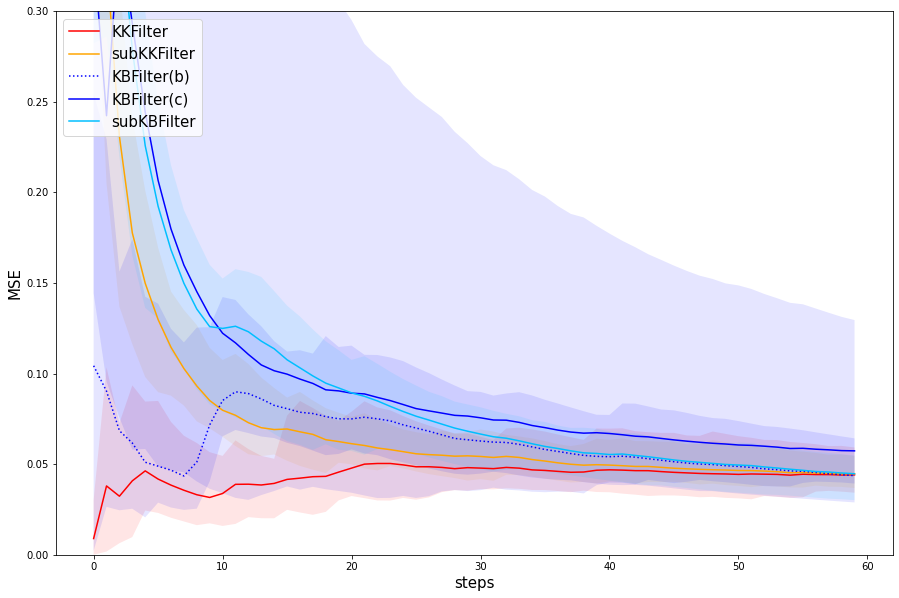

In [135]:
fig, ax = plt.subplots(figsize=(15,10))

x = [i for i in range(nSteps)]
kkfPlt = ax.plot(x, np.mean([((testData['KKFiltered'][ei] - testData['theta'][ei])**2).expanding().mean() for ei in range(nTestEpisodes)], axis=0), color="red")
subkkfPlt = ax.plot(x, np.mean([((testData['subKKFiltered'][ei] - testData['theta'][ei])**2).expanding().mean() for ei in range(nTestEpisodes)], axis=0), color="orange")
# ax.plot(x, np.mean([((testData['KBFiltered(a)'][ei] - testData['theta'][ei])**2).expanding().mean() for ei in range(nTestEpisodes)], axis=0), color="blue", linestyle="dashed")
kbfbPlt = ax.plot(x, np.mean([((testData['KBFiltered(b)'][ei] - testData['theta'][ei])**2).expanding().mean() for ei in range(nTestEpisodes)], axis=0), color="blue", linestyle="dotted")
kbfcPlt = ax.plot(x, np.mean([((testData['KBFiltered(c)'][ei] - testData['theta'][ei])**2).expanding().mean() for ei in range(nTestEpisodes)], axis=0), color="blue")
subkbfPlt = ax.plot(x, np.mean([((testData['subKBFiltered'][ei] - testData['theta'][ei])**2).expanding().mean() for ei in range(nTestEpisodes)], axis=0), color="deepskyblue")

ax.set_xlabel('steps', fontsize="15")
ax.set_ylabel('MSE',  fontsize="15")
ax.set_ylim(0, 0.3)
ax.legend((kkfPlt[0], subkkfPlt[0], kbfbPlt[0], kbfcPlt[0],  subkbfPlt[0],), ("KKFilter", "subKKFilter", "KBFilter(b)", "KBFilter(c)", "subKBFilter"), loc=2, fontsize=15)

for filterm, color in [ ("KKFiltered", "red"), ("subKKFiltered", "orange"), ("KBFiltered(b)", "blue"), ("KBFiltered(c)", "blue"), ("subKBFiltered", "deepskyblue")]:
    ax.fill_between(x, np.min([((testData[filterm][ei] - testData['theta'][ei])**2).expanding().mean() for ei in range(nTestEpisodes)], axis=0), np.max([((testData[filterm][ei] - testData['theta'][ei])**2).expanding().mean() for ei in range(nTestEpisodes)], axis=0), facecolor=color, alpha=0.1)
    
    
    
    

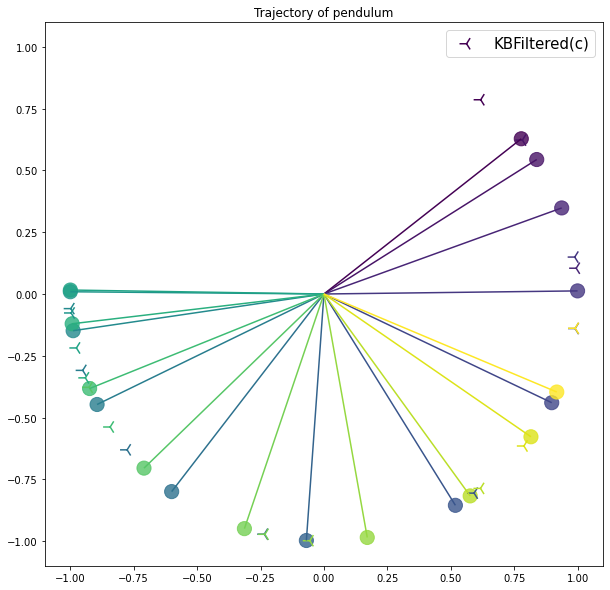

In [68]:
num = 20

x = np.sin(testData.loc[(0,slice(None)),'theta'].reset_index(drop=True)[:num])
y = np.cos(testData.loc[(0,slice(None)),'theta'].reset_index(drop=True)[:num])

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_title('Trajectory of pendulum')

# pendulum thread
line_segments = LineCollection([np.array([[0,0],val]) for i, val in enumerate(np.column_stack([x, y]))], linestyles='solid')
line_segments.set_array(np.arange(num))
ax.add_collection(line_segments)

plt.sci(line_segments)  # This allows interactive changing of the colormap.

#  pendulum ball
ax.scatter(x, y, s=200, c=np.arange(num), alpha=0.8)

#  observation
fil_x = np.sin(testData.loc[(0,slice(None)), 'KBFiltered(c)'].reset_index(drop=True)[:num])
fil_y = np.cos(testData.loc[(0,slice(None)), 'KBFiltered(c)'].reset_index(drop=True)[:num])
fil_points = ax.scatter(obs_x, obs_y, s=200, c=np.arange(num), marker="3")


# obs_x = np.sin(testData.loc[(0,slice(None)), 'thetaNoisy'].reset_index(drop=True)[:num])
# obs_y = np.cos(testData.loc[(0,slice(None)), 'thetaNoisy'].reset_index(drop=True)[:num])
# obs_points = ax.scatter(obs_x, obs_y, s=100, c="black", marker="x", alpha=0.5)

ax.legend([fil_points], ["KBFiltered(c)"], fontsize=15)

plt.show()

In [69]:
a = np.array([[1,6], [3,5]])
print(np.min(a, axis=0))

[1 5]
